### Hedging

Hedging in Finance, is taking an offsetting position in an asset or investment to reduce the price risk of an existing position. Normally, a hedge involves taking the opposite position in a related security or derivative security based on the asset being hedged.

Derivatives can be effective hedges against their underlying assets because the relationship between the two is relatively clearly defined. Derivatives include futures, options, swaps, and forward contracts. They move in correspondance with underlying assets like stocks, bonds, commodities, currencies, indexes, or interest rates. 

### CAPM

A formula for calculating the expected return of a security based on its systematic risk

ri = rf + Bi(rm - rf) where ri is the expected return of security i, rf is the risk free rate, Bi is the beta of security i, and rm is the expected return of the market.

higher systematic risk -> higher expected return 

### Beta Hedge

Beta is a measure of volatility of a security or portfolio compared to the market as whole (usually the S&P 500). Stocks with Beta higher than 1 can be interpreted as more volatile than the S&P 500.

Beta = Covariance(ri,rm)/variance(rm)

Beta hedging involves reducing the unsystematic risk by purchasing stocks with offsetting betas so that the overall portfolio has the same general riskiness as the S&P 500 broad market index.

For example, if an investor's portfolio beta is +2, to have a beta neutral portfolio, the investor would want to purchase the same amount of stocks with a beta of -2. 

### Minimum Variance Hedge

When using futures contracts to hedge a portfolio, the ideal futures contract may not exist. Or additionaly, if there exists a futures market for an underlying asset, the market is too illiquid to be functionally useful. 

To circumvent this, we need sub-optimal contracts that are highly correlated with the underlying asset and have similar variance. This is achieved using minimum variance hedge.

MVH is the ratio of futures position relative to the spot position that minimizes the variance of the position.

h = corr*(sd(s)/sd(F))

optimal contracts to buy = ((size of desired underlying portfolio)/(contract size of ones futures contract)) * h

### Calculating Beta of a Portfolio

#### Get the portfolio returns

In [152]:
from datetime import datetime
import pandas as pd
import requests
from typing import *
import time
import matplotlib.pyplot as plt
import statistics
from scipy.stats import skew
from pandas_datareader import data as pdr
import datetime as dt
import statistics

In [153]:
tickers = ['SHIBUSDT', 'ETHUSDT', 'SOLUSDT', 'XRPUSDT', 'LTCUSDT']
weights = [0.2,0.2,0.2,0.2,0.2]

In [154]:
class BinanceClient:
    def __init__(self, futures=False):
        self.exchange = "BINANCE"
        self.futures = futures

        if self.futures:
            self._base_url = "https://fapi.binance.com"
        else:
            self._base_url = "https://api.binance.com"

        self.symbols = self._get_symbols()

    def _make_request(self, endpoint: str, query_parameters: Dict):
        try:
            response = requests.get(self._base_url + endpoint, params=query_parameters)
        except Exception as e:
            print("Connection error while making request to %s: %s", endpoint, e)
            return None

        if response.status_code == 200:
            return response.json()
        else:
            print("Error while making request to %s: %s (status code = %s)",
                         endpoint, response.json(), response.status_code)
            return None

    def _get_symbols(self) -> List[str]:

        params = dict()

        endpoint = "/fapi/v1/exchangeInfo" if self.futures else "/api/v3/exchangeInfo"
        data = self._make_request(endpoint, params)

        symbols = [x["symbol"] for x in data["symbols"]]

        return symbols

    def get_historical_data(self, symbol: str, interval: Optional[str] = "1m", start_time: Optional[int] = None, end_time: Optional[int] = None, limit: Optional[int] = 1500):

        params = dict()

        params["symbol"] = symbol
        params["interval"] = interval
        params["limit"] = limit

        if start_time is not None:
            params["startTime"] = start_time
        if end_time is not None:
            params["endTime"] = end_time

        endpoint = "/fapi/v1/klines" if self.futures else "/api/v3/klines"
        raw_candles = self._make_request(endpoint, params)

        candles = []

        if raw_candles is not None:
            for c in raw_candles:
                candles.append((float(c[0]), float(c[1]), float(c[2]), float(c[3]), float(c[4]), float(c[5]),))
            return candles
        else:
            return None

def ms_to_dt_utc(ms: int) -> datetime:
    return datetime.utcfromtimestamp(ms / 1000)

def ms_to_dt_local(ms: int) -> datetime:
    return datetime.fromtimestamp(ms / 1000)

def GetDataFrame(data):
    df = pd.DataFrame(data, columns=['Timestamp', "Open", "High", "Low", "Close", "Volume"])
    df["Timestamp"] = df["Timestamp"].apply(lambda x: ms_to_dt_local(x))
    df['Date'] = df["Timestamp"].dt.strftime("%d/%m/%Y")
    df['Time'] = df["Timestamp"].dt.strftime("%H:%M:%S")
    column_names = ["Date", "Time", "Open", "High", "Low", "Close", "Volume"]
    df = df.set_index('Timestamp')
    df = df.reindex(columns=column_names)

    return df

def GetHistoricalData(client, symbol, start_time, end_time, limit=1500):
    collection = []

    while start_time < end_time:
        data = client.get_historical_data(symbol, start_time=start_time, end_time=end_time, limit=limit)
        print(client.exchange + " " + symbol + " : Collected " + str(len(data)) + " initial data from "+ str(ms_to_dt_local(data[0][0])) +" to " + str(ms_to_dt_local(data[-1][0])))
        start_time = int(data[-1][0] + 1000)
        collection +=data
        time.sleep(1.1)

    return collection

In [155]:
df_list = []
for ticker in tickers:
    client = BinanceClient(futures=False)
    interval = "1d"
    rolling_window = 30
    fromDate = int(datetime.strptime(f'2022-1-1', '%Y-%m-%d').timestamp() * 1000)
    toDate = int(datetime.strptime('2023-1-1', '%Y-%m-%d').timestamp() * 1000)
    df = GetDataFrame(client.get_historical_data(ticker, interval, fromDate, toDate))
    df_list.append(df)

In [156]:
data = pd.DataFrame()
for index, df in enumerate(df_list):
    data[f'Close {index}'] = df['Close']

In [157]:
for i in range(len(df_list)):
    data[f'Daily Return {i}'] = data[f'Close {i}'].pct_change(1) * 100

In [158]:
returns_df = pd.DataFrame()
for i in range(len(df_list)):
    returns_df[f'Daily Return {i}'] = data[f'Daily Return {i}'] * weights[i]
returns_df = returns_df.reset_index()
portfolio_returns = (returns_df.sum(axis = 1)).to_list()
portfolio_returns

/var/folders/x4/625nnk3x0vldg0knqtsvs__m0000gq/T/ipykernel_63163/2458385068.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  portfolio_returns = (returns_df.sum(axis = 1)).to_list()


[0.0,
 0.18727605179043705,
 -2.5668976321905213,
 -1.052824183062251,
 -6.8656941192513825,
 -0.8215960500175568,
 -5.253694617792409,
 -1.5760597539378152,
 1.0988686699328998,
 -3.268742189670819,
 3.990187144289017,
 7.49328988054908,
 -4.123919731521524,
 2.477524222284919,
 0.9134831303924162,
 -0.2431941692684103,
 -2.7942713445765737,
 -2.201346059088858,
 -2.9856963311783513,
 -3.7246371960630476,
 -13.111514072302706,
 -8.238940749172876,
 5.822526507805006,
 -4.504850378296313,
 0.4692493341494508,
 -0.544107389090529,
 -1.0497056007417083,
 1.891889094081749,
 2.37862188827628,
 -2.0336712904189658,
 2.9891809965002114,
 4.466958385229387,
 -5.281450096825249,
 1.0429031742735684,
 9.083303569887992,
 0.9721241433613237,
 7.351946743967135,
 9.705413077469444,
 -1.2858612832304472,
 2.986993864315304,
 -5.506600265886439,
 -7.082821749101941,
 1.9696489029433706,
 -0.8732727603864587,
 0.5238908242665796,
 7.123981327269524,
 -2.21109603859734,
 -8.274447691676446,
 -1.4815

#### Get the BTC returns

In [159]:
client = BinanceClient(futures=False)
instrument = "BTCUSDT"
interval = "1d"
rolling_window = 30
fromDate = int(datetime.strptime(f'2022-1-1', '%Y-%m-%d').timestamp() * 1000)
toDate = int(datetime.strptime('2023-1-1', '%Y-%m-%d').timestamp() * 1000)
df = GetDataFrame(client.get_historical_data(instrument, interval, fromDate, toDate))
df['Daily Return'] = df['Close'].pct_change(1) * 100
df = df.fillna(0)
df = df.reset_index()
market_returns = df['Daily Return'].to_list()
market_returns

[0.0,
 -0.9145971566960398,
 -1.776586732106511,
 -1.3221562197902492,
 -5.19479726069183,
 -0.8488156694659077,
 -3.51845107655554,
 0.2724791707163998,
 0.4435728245905768,
 -0.10063390041520348,
 2.168211409698473,
 2.7460554575093665,
 -3.058015163545902,
 1.1744565509816507,
 0.05650260706233645,
 -0.02931462953200681,
 -2.0199825128634497,
 0.3566213808853691,
 -1.6341802960513019,
 -2.3502154704235556,
 -10.411763158690412,
 -3.7697305908496848,
 3.3449743409305954,
 1.1472069593911227,
 0.8127854753159802,
 -0.4031027384361674,
 0.9529103211304513,
 1.497466368497391,
 1.1938522495158699,
 -0.7469311056403805,
 1.544648400707893,
 0.5919114875386322,
 -4.647238800049303,
 1.1254497733651725,
 11.424433306415892,
 -0.4610065124446061,
 2.412318803632174,
 3.442874108058658,
 0.4630475508776266,
 0.7486548937753801,
 -1.977070596528674,
 -2.5789140194926174,
 -0.3678222332563097,
 -0.38895851448687013,
 1.146820514552127,
 4.722876701443535,
 -1.5070201141052064,
 -7.653493356819

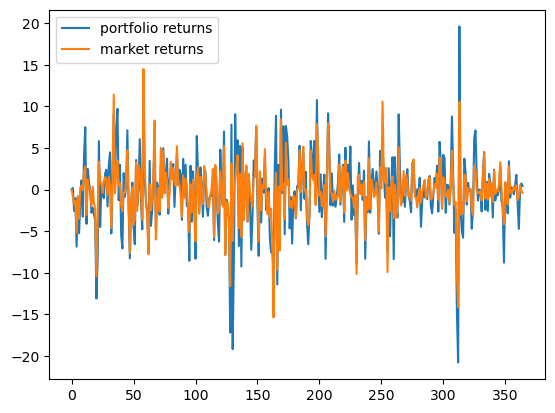

In [160]:
plt.plot(portfolio_returns, label = 'portfolio returns')
plt.plot(market_returns, label = 'market returns')
plt.legend()
plt.show()

In [162]:
cov = np.cov(portfolio_returns, market_returns)[0,1]
var = statistics.variance(market_returns)
beta = cov/var
print(f'Beta is {beta}')

Beta is 1.1836696639839388
